In [19]:
import pandas as pd

# Charger le fichier CSV
df = pd.read_csv('dft-road-casualty-statistics-casualty-provisional-mid-year-unvalidated-2023.csv')

# Afficher les premières lignes du DataFrame pour comprendre sa structure
print(df.head())

# Obtenir des statistiques descriptives
print(df.describe())

# Vérifier les types de données et les valeurs manquantes
print(df.info())


  collision_index  collision_year collision_reference  vehicle_reference  \
0   2023010419171            2023           010419171                  1   
1   2023010419183            2023           010419183                  2   
2   2023010419183            2023           010419183                  3   
3   2023010419189            2023           010419189                  1   
4   2023010419191            2023           010419191                  2   

   casualty_reference  casualty_class  sex_of_casualty  age_of_casualty  \
0                   1               3                2               20   
1                   1               1                1               25   
2                   2               2                2               38   
3                   1               1                1               50   
4                   1               1                1               34   

   age_band_of_casualty  casualty_severity  pedestrian_location  \
0                     4  

In [20]:
# Remplacer les valeurs -1 par NaN pour les traiter comme des valeurs manquantes
import numpy as np
df.replace(-1, np.nan, inplace=True)

# Vous pouvez choisir de les imputer ou de supprimer les lignes/colonnes avec des valeurs manquantes
# Par exemple, pour supprimer les lignes avec des valeurs manquantes :
df_clean = df.dropna()

# Encodage des variables catégorielles (si nécessaire)
df_encoded = pd.get_dummies(df_clean, columns=['sex_of_casualty', 'casualty_class', 'casualty_severity'], drop_first=True)


In [21]:
X = df_encoded.drop('casualty_severity_2', axis=1)  # Supposons que casualty_severity_2 est notre cible après encodage
y = df_encoded['casualty_severity_2']


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [23]:
# Identifier les colonnes numériques
num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Supposons que 'casualty_severity' est ta colonne cible
# Assure-toi de ne pas inclure la colonne cible dans X si elle est numérique
num_cols = num_cols.drop('casualty_severity')

X = df_clean[num_cols]

# Supposons que y est ta colonne cible
y = df_clean['casualty_severity']


In [24]:
columns_to_drop = ['collision_index', 'collision_reference', 'lsoa_of_casualty']

X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)


In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [26]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(10, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sortie binaire

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=10)


Epoch 1/50


C:\Users\zaebo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3035/3035 ━━━━━━━━━━━━━━━━━━━━ 2s 425us/step - accuracy: 0.9224 - loss: 0.1918 - val_accuracy: 0.9887 - val_loss: 0.0445
Epoch 2/50
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step - accuracy: 0.9887 - loss: 0.0438 - val_accuracy: 0.9887 - val_loss: 0.0433
Epoch 3/50
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step - accuracy: 0.9881 - loss: 0.0450 - val_accuracy: 0.9887 - val_loss: 0.0458
Epoch 4/50
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step - accuracy: 0.9889 - loss: 0.0433 - val_accuracy: 0.9887 - val_loss: 0.0434
Epoch 5/50
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1s 398us/step - accuracy: 0.9893 - loss: 0.0411 - val_accuracy: 0.9887 - val_loss: 0.0447
Epoch 6/50
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step - accuracy: 0.9897 - loss: 0.0401 - val_accuracy: 0.9887 - val_loss: 0.0436
Epoch 7/50
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1s 392us/step - accuracy: 0.9891 - loss: 0.0418 - val_accuracy: 0.9887 - val_loss: 0.0439
Epoch 8/50
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step - accuracy: 0.9893 - loss: 0.04

In [27]:
# Supposons que 'y_train' est ta variable cible
print(y_train.value_counts())


casualty_severity_2
False    30610
True      7322
Name: count, dtype: int64


In [29]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Vérifier l'équilibre des classes après suréchantillonnage
print(pd.Series(y_train_smote).value_counts())


casualty_severity_2
True     30610
False    30610
Name: count, dtype: int64


In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(16, input_dim=X_train_smote.shape[1], activation='relu')) # Ajuste la dimension d'entrée selon tes données
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Utilise une sortie sigmoïde pour la classification binaire

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_smote, y_train_smote, epochs=50, batch_size=10, validation_split=0.2)


Epoch 1/50


C:\Users\zaebo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4898/4898 ━━━━━━━━━━━━━━━━━━━━ 3s 440us/step - accuracy: 0.9586 - loss: 0.1576 - val_accuracy: 1.0000 - val_loss: 0.0160
Epoch 2/50
4898/4898 ━━━━━━━━━━━━━━━━━━━━ 2s 429us/step - accuracy: 0.9912 - loss: 0.0463 - val_accuracy: 1.0000 - val_loss: 0.0196
Epoch 3/50
4898/4898 ━━━━━━━━━━━━━━━━━━━━ 2s 425us/step - accuracy: 0.9909 - loss: 0.0435 - val_accuracy: 1.0000 - val_loss: 0.0244
Epoch 4/50
4898/4898 ━━━━━━━━━━━━━━━━━━━━ 2s 422us/step - accuracy: 0.9901 - loss: 0.0451 - val_accuracy: 1.0000 - val_loss: 0.0197
Epoch 5/50
4898/4898 ━━━━━━━━━━━━━━━━━━━━ 2s 412us/step - accuracy: 0.9904 - loss: 0.0440 - val_accuracy: 1.0000 - val_loss: 0.0201
Epoch 6/50
4898/4898 ━━━━━━━━━━━━━━━━━━━━ 2s 413us/step - accuracy: 0.9897 - loss: 0.0449 - val_accuracy: 1.0000 - val_loss: 0.0231
Epoch 7/50
4898/4898 ━━━━━━━━━━━━━━━━━━━━ 2s 422us/step - accuracy: 0.9899 - loss: 0.0451 - val_accuracy: 1.0000 - val_loss: 0.0236
Epoch 8/50
4898/4898 ━━━━━━━━━━━━━━━━━━━━ 2s 414us/step - accuracy: 0.9907 - loss: 0.04

In [31]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - accuracy: 0.9872 - loss: 0.0496
Test Loss: 0.0466, Test Accuracy: 0.9885


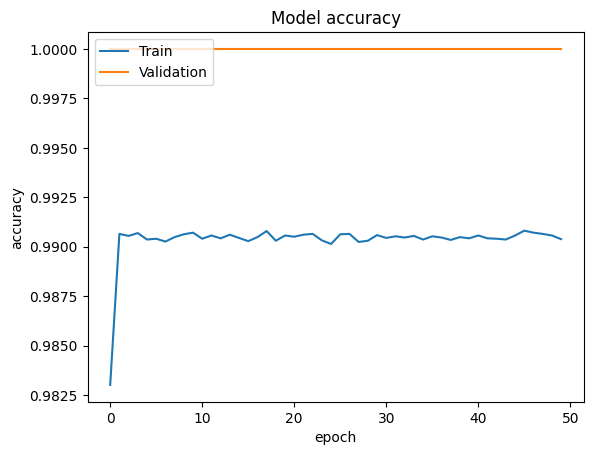

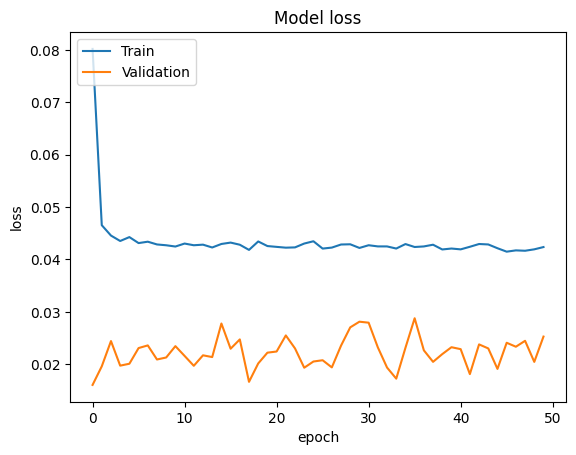

In [32]:
import matplotlib.pyplot as plt

# Tracer l'accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Tracer la loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [33]:
from sklearn.metrics import confusion_matrix

# Prédictions
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print(cm)

TN, FP, FN, TP = cm.ravel()

print(f"Vrais Négatifs (TN): {TN}")
print(f"Faux Positifs (FP): {FP}")
print(f"Faux Négatifs (FN): {FN}")
print(f"Vrais Positifs (TP): {TP}")


509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
[[12966   187]
 [    0  3104]]
Vrais Négatifs (TN): 12966
Faux Positifs (FP): 187
Faux Négatifs (FN): 0
Vrais Positifs (TP): 3104
